Hack of original causal tracing NB to work with Qwen2-1.5B-Instruct (Orignal: https://github.com/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb)

<a href="https://colab.research.google.com/github/jtf9808/rank-one-model-editing/blob/main/notebooks/causal_trace_qwen.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install datasets

  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.17-py310-none-any.whl.metadata (7.2 kB)
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)


The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [5]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
class QwenModelAndTokenizer:
    """
    An object to hold on to (or automatically download and hold)
    a GPT-style language model and tokenizer.  Counts the number
    of layers.
    """

    def __init__(
        self,
        model_name=None,
        model=None,
        tokenizer=None,
        low_cpu_mem_usage=False,
        torch_dtype=None,
    ):
        if tokenizer is None:
            assert model_name is not None
            tokenizer = AutoTokenizer.from_pretrained(model_name)
        if model is None:
            assert model_name is not None
            model = AutoModelForCausalLM.from_pretrained(
                model_name, low_cpu_mem_usage=low_cpu_mem_usage, torch_dtype=torch_dtype
            )
            nethook.set_requires_grad(False, model)
            model.eval().cuda()
        self.tokenizer = tokenizer
        self.model = model
        self.layer_names = [
            n
            for n, m in model.named_modules()
            if (re.match(r"^(model)\.(h|layers)\.\d+$", n))
        ]
        self.num_layers = len(self.layer_names)

    def __repr__(self):
        return (
            f"ModelAndTokenizer(model: {type(self.model).__name__} "
            f"[{self.num_layers} layers], "
            f"tokenizer: {type(self.tokenizer).__name__})"
        )

In [10]:
# Overwrite layername function so it works with qwen
def layername(model, num, kind=None):
    if hasattr(model, "transformer"):
        if kind == "embed":
            return "transformer.wte"
        return f'transformer.h.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "gpt_neox"):
        if kind == "embed":
            return "gpt_neox.embed_in"
        if kind == "attn":
            kind = "attention"
        return f'gpt_neox.layers.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "model"):
        if kind == "embed":
            return "model.embed_tokens"
        if kind == "attn":
            kind = "self_attn"
        return f'model.layers.{num}{"" if kind is None else "." + kind}'
    assert False, "unknown transformer structure"

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [11]:
model_name = "Qwen/Qwen2-1.5B-Instruct"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = QwenModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [12]:
mt.layer_names

['model.layers.0',
 'model.layers.1',
 'model.layers.2',
 'model.layers.3',
 'model.layers.4',
 'model.layers.5',
 'model.layers.6',
 'model.layers.7',
 'model.layers.8',
 'model.layers.9',
 'model.layers.10',
 'model.layers.11',
 'model.layers.12',
 'model.layers.13',
 'model.layers.14',
 'model.layers.15',
 'model.layers.16',
 'model.layers.17',
 'model.layers.18',
 'model.layers.19',
 'model.layers.20',
 'model.layers.21',
 'model.layers.22',
 'model.layers.23',
 'model.layers.24',
 'model.layers.25',
 'model.layers.26',
 'model.layers.27']

In [13]:
[
            n
            for n, m in mt.model.named_modules()
        ]

['',
 'model',
 'model.embed_tokens',
 'model.layers',
 'model.layers.0',
 'model.layers.0.self_attn',
 'model.layers.0.self_attn.q_proj',
 'model.layers.0.self_attn.k_proj',
 'model.layers.0.self_attn.v_proj',
 'model.layers.0.self_attn.o_proj',
 'model.layers.0.self_attn.rotary_emb',
 'model.layers.0.mlp',
 'model.layers.0.mlp.gate_proj',
 'model.layers.0.mlp.up_proj',
 'model.layers.0.mlp.down_proj',
 'model.layers.0.mlp.act_fn',
 'model.layers.0.input_layernorm',
 'model.layers.0.post_attention_layernorm',
 'model.layers.1',
 'model.layers.1.self_attn',
 'model.layers.1.self_attn.q_proj',
 'model.layers.1.self_attn.k_proj',
 'model.layers.1.self_attn.v_proj',
 'model.layers.1.self_attn.o_proj',
 'model.layers.1.self_attn.rotary_emb',
 'model.layers.1.mlp',
 'model.layers.1.mlp.gate_proj',
 'model.layers.1.mlp.up_proj',
 'model.layers.1.mlp.down_proj',
 'model.layers.1.mlp.act_fn',
 'model.layers.1.input_layernorm',
 'model.layers.1.post_attention_layernorm',
 'model.layers.2',
 'mo

In [14]:
predict_token(
    mt,
    ["Megan Rapinoe plays the sport of", "The Space Needle is in the city of"],
    return_p=True,
)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


([' soccer', ' Seattle'], tensor([0.5760, 0.5328], device='cuda:0'))

In [17]:
import experiments
experiments.causal_trace.layername = layername

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [18]:

knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 1209 elements
Using noise level 0.050920721143484116


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [19]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [20]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [21]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

The following prompt can be changed to any factual statement to trace.

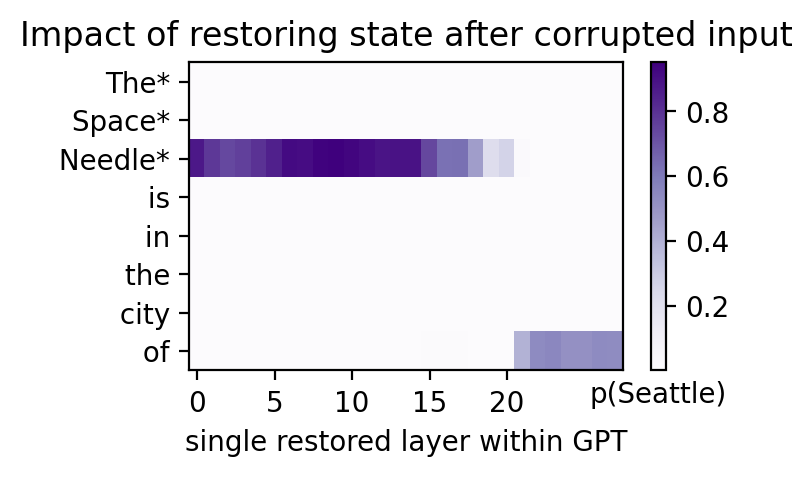

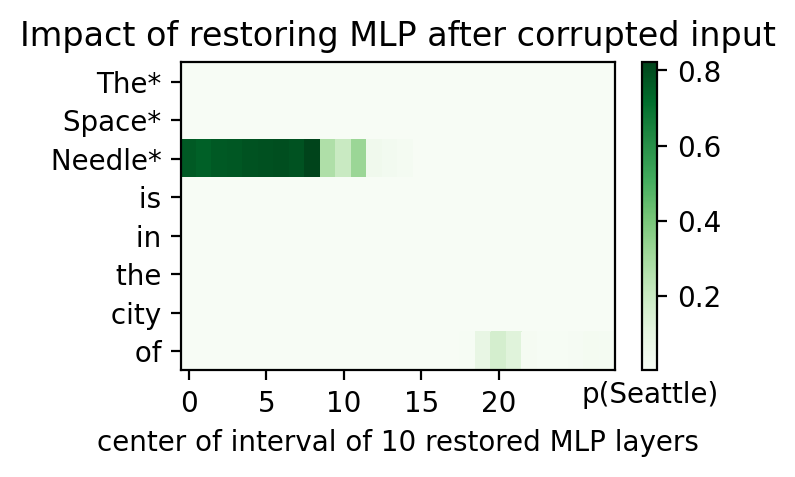

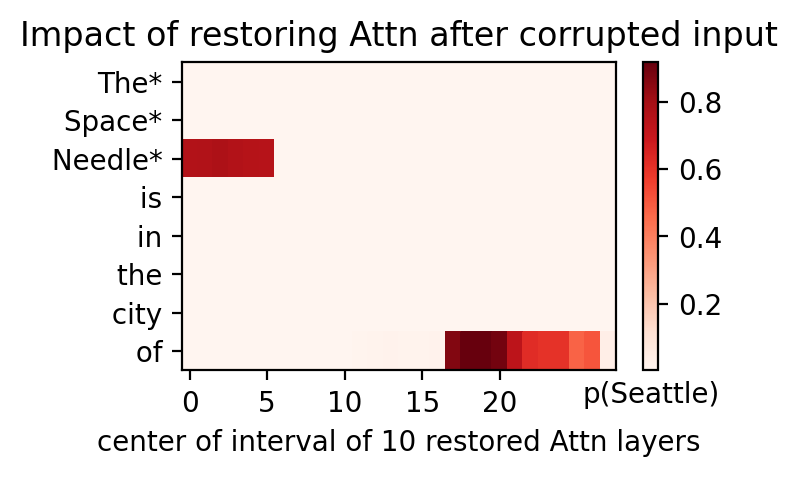

In [22]:
plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level)

Here we trace a few more factual statements from a file of test cases.

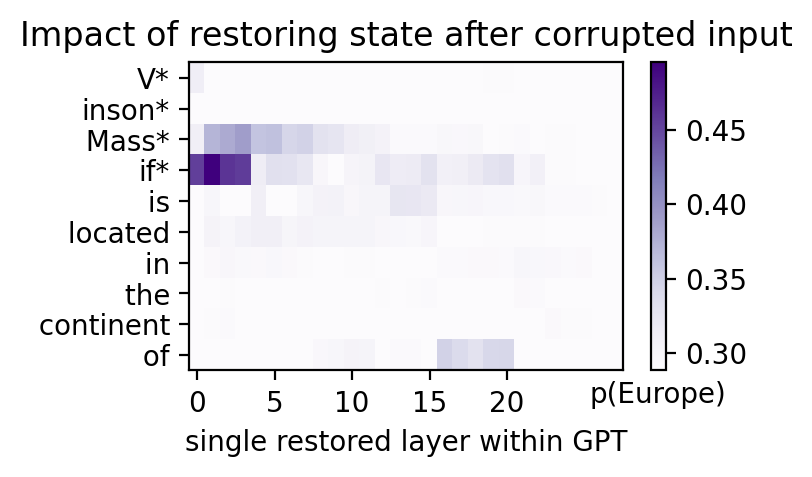

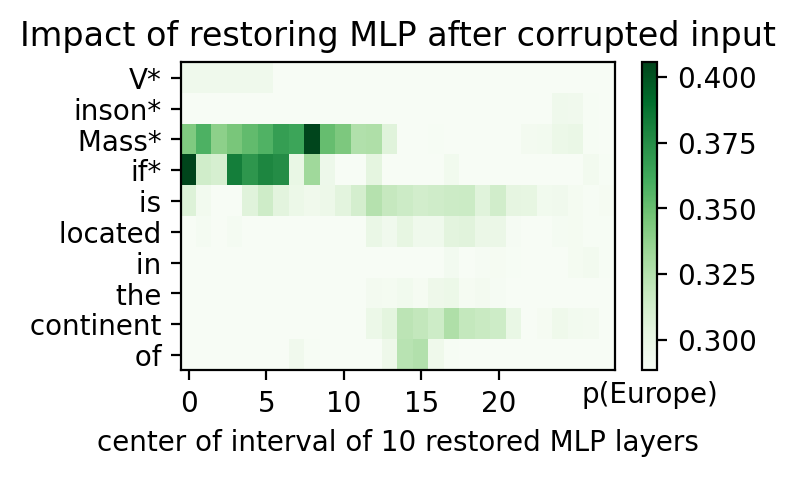

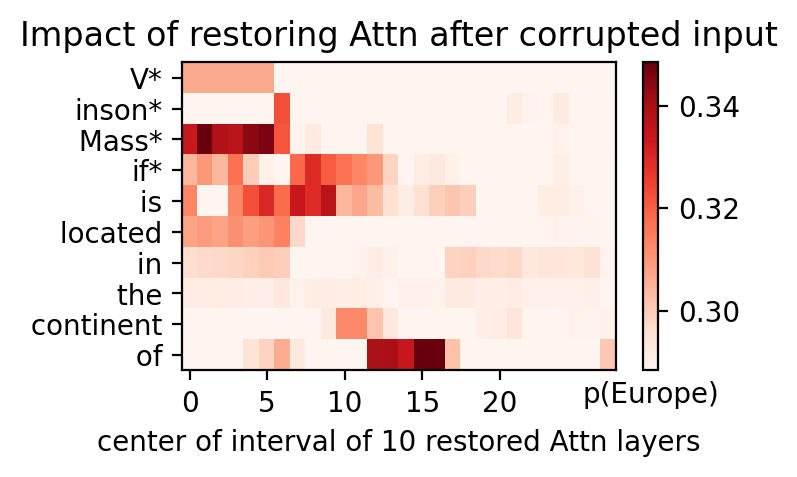

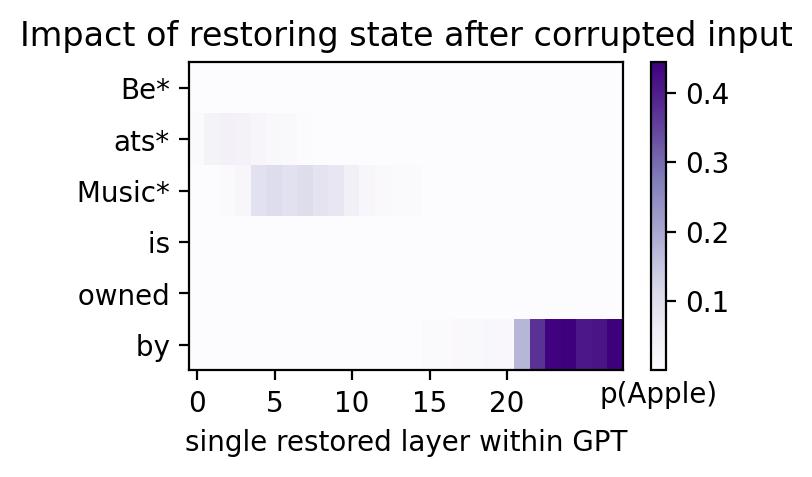

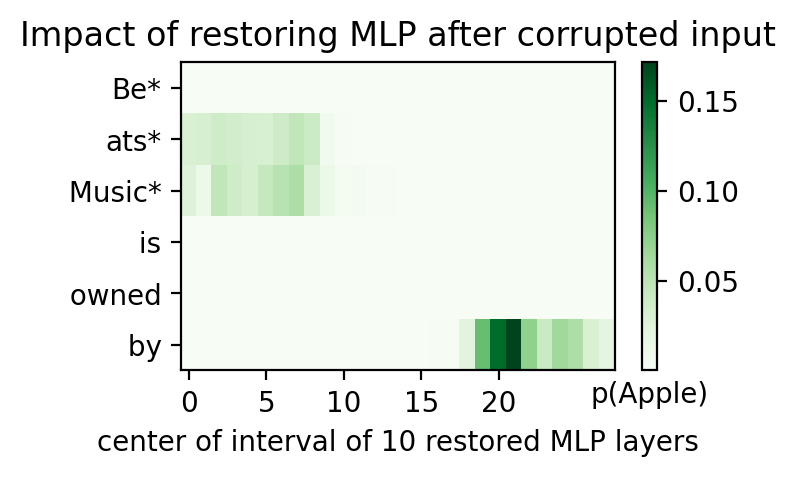

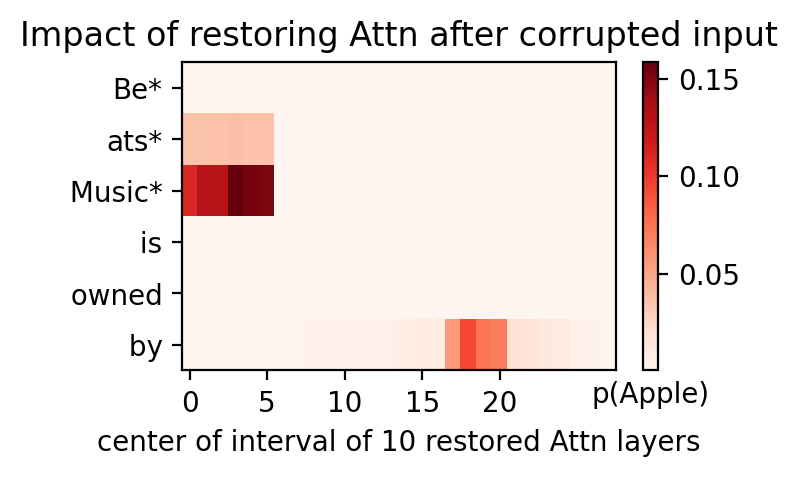

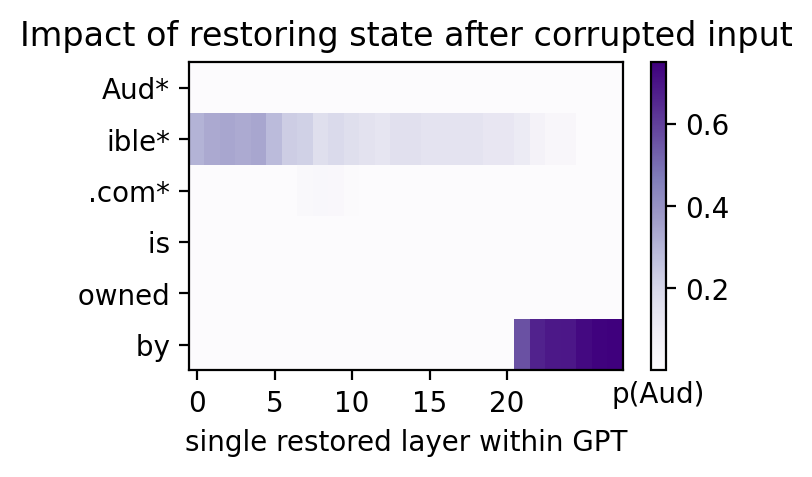

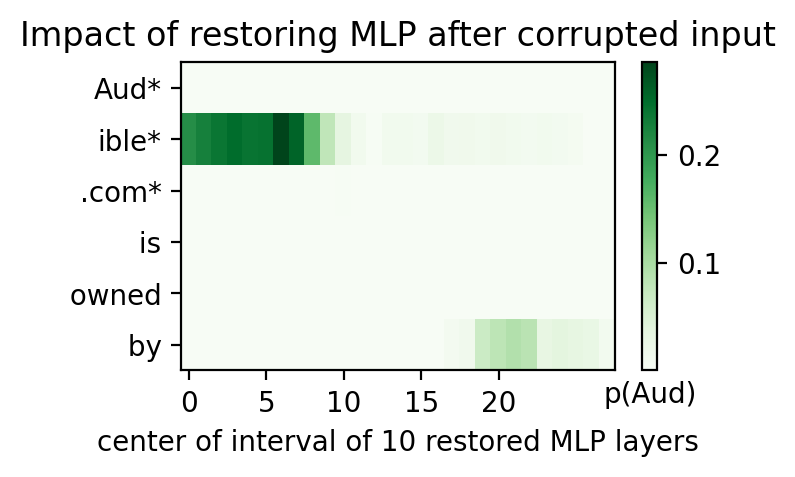

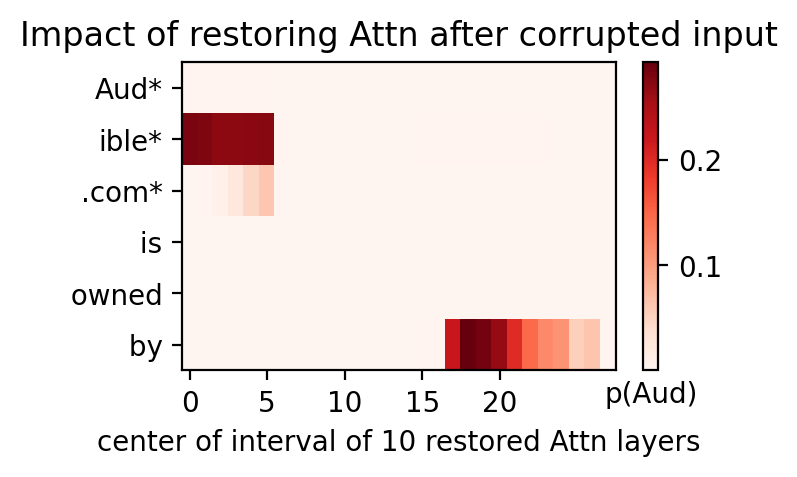

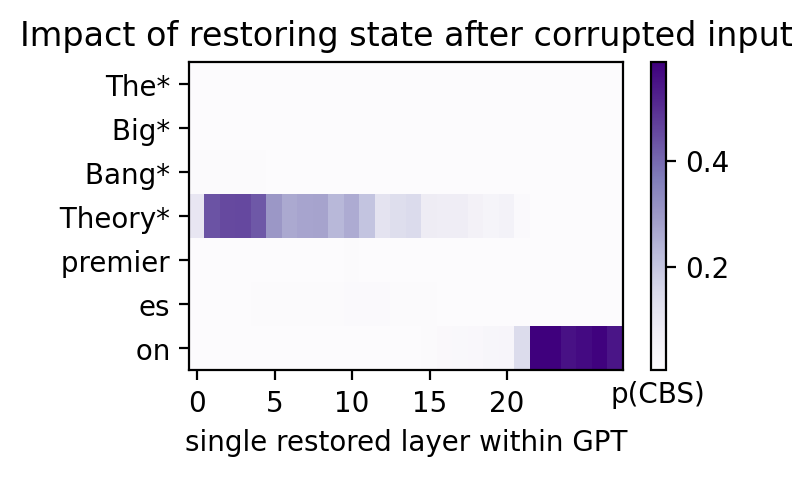

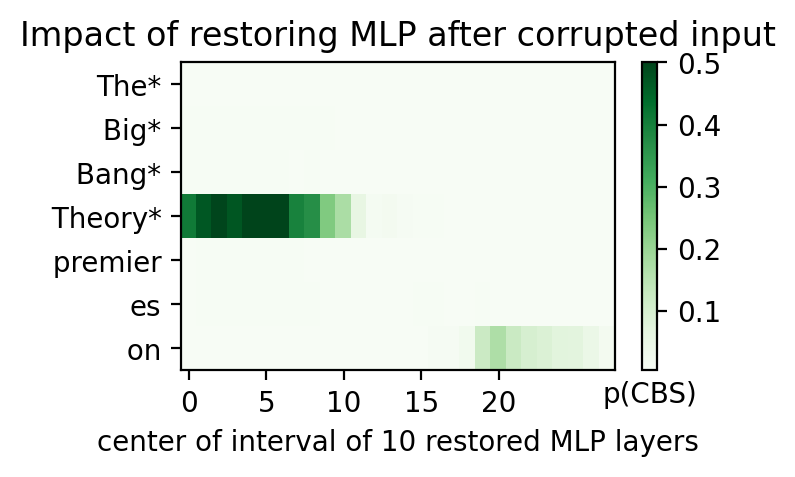

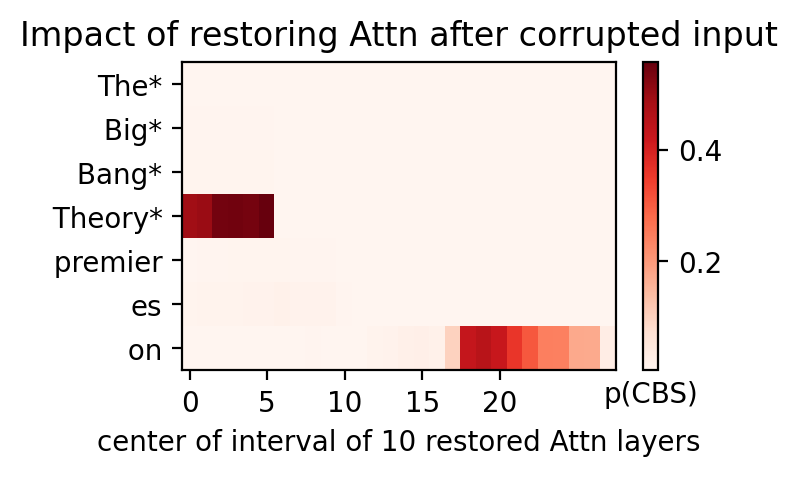

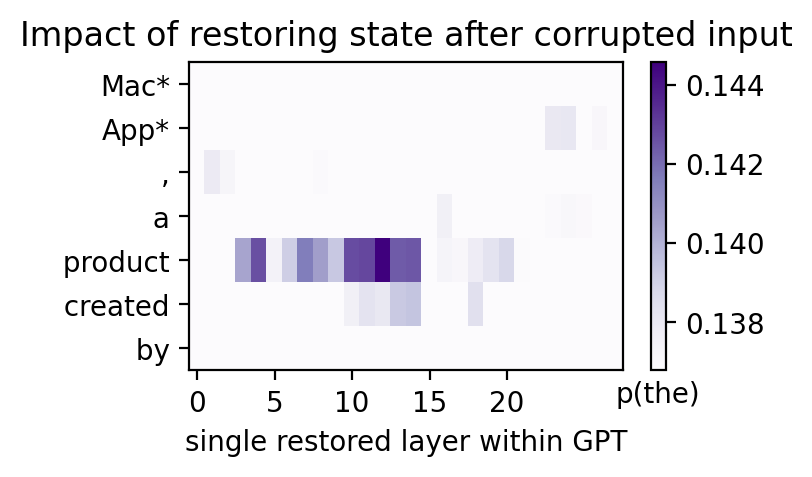

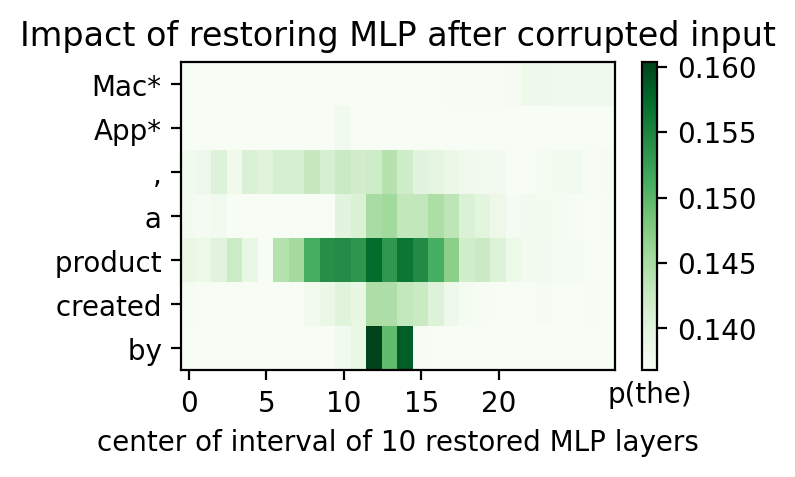

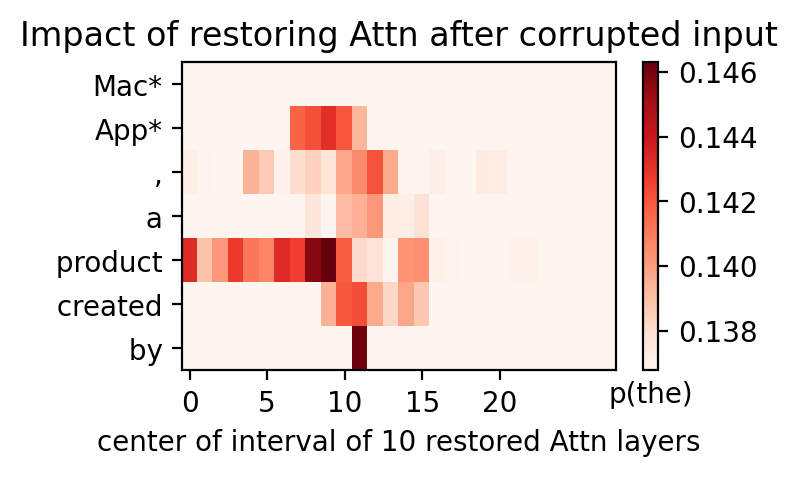

In [23]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)